# Analisis exploratorio de datos (EDA) de las reseñas de películas

Se carga el dataset de IMDB 50k Movie Reviews, que contiene reseñas de películas junto con sus calificaciones (positivas o negativas). El objetivo es realizar un análisis exploratorio de datos para entender mejor la distribución e identificar limpiezas necesarias.


In [1]:
from pathlib import Path
import string
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

import re 
from collections import Counter 
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    WordNetLemmatizer().lemmatize('test')
except LookupError:
    nltk.download('wordnet')
    nltk.download('omw-1.4')

DATA_PATH = Path("../data/")
file_path = DATA_PATH / "raw/punto_2_3.csv"
stop_words = set(stopwords.words('english'))

label_map = {0: 'negative', 1: 'positive'}

In [11]:
df = pd.read_csv(file_path)

In [12]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   review     50000 non-null  str  
 1   sentiment  50000 non-null  int64
dtypes: int64(1), str(1)
memory usage: 781.4 KB


In [13]:
df.head()

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


In [14]:
print("Sentimiento: ", df.loc[1, 'sentiment'])
print("Reseña: ", df.loc[1, 'review'])

Sentimiento:  0
Reseña:  OK... so... I really like Kris Kristofferson and his usual easy going delivery of lines in his movies. Age has helped him with his soft spoken low energy style and he will steal a scene effortlessly. But, Disappearance is his misstep. Holy Moly, this was a bad movie! <br /><br />I must give kudos to the cinematography and and the actors, including Kris, for trying their darndest to make sense from this goofy, confusing story! None of it made sense and Kris probably didn't understand it either and he was just going through the motions hoping someone would come up to him and tell him what it was all about! <br /><br />I don't care that everyone on this movie was doing out of love for the project, or some such nonsense... I've seen low budget movies that had a plot for goodness sake! This had none, zilcho, nada, zippo, empty of reason... a complete waste of good talent, scenery and celluloid! <br /><br />I rented this piece of garbage for a buck, and I want my mon

In [15]:
has_duplicated = df.duplicated().sum()
print(f"Number of duplicated rows: {has_duplicated}")

Number of duplicated rows: 418


In [16]:
if has_duplicated > 0:
    df = df.drop_duplicates()
    print("Duplicated rows have been removed.")

Duplicated rows have been removed.


In [17]:
lemmatizer = WordNetLemmatizer()

def clean_text(txt) : 
    txt = txt.lower()
    txt = re.sub(r'http\S+|www\S+|https\S+' , ' ' , txt , flags=re.MULTILINE) # URLs
    txt = re.sub(r'(.)\1\1+' , r'\1' , txt) # repeated characters 
    txt = re.sub(r'<.*?>', ' ', txt) # remove HTML tags
    txt = re.sub(r'[^a-zA-Z0-9\s]' , ' ' , txt) # symbols
    txt = re.sub(r"[^\w\s]", ' ', txt) # non-word characters
    txt = re.sub(r"\s+", ' ', txt) # whitespaces with no space
    txt = re.sub(r"\d", ' ', txt) # digits with no space
    txt = txt.translate(str.maketrans('', '', string.punctuation)) # punctuation
    tokens = simple_preprocess(txt, deacc=True) # tokenization
    tokens = [word for word in tokens if word not in stop_words] # remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens] # lemmatization
    txt = ' '.join(tokens)

    return txt

In [18]:
df['cleaned_review'] = df['review'].apply(clean_text)

In [19]:
df.drop_duplicates(inplace=True)

In [20]:
df.dropna(inplace=True)

In [21]:
df[['cleaned_review', 'review']].head()

,cleaned_review,review
0,teenager martha moxley maggie grace move high ...,"In 1974, the teenager Martha Moxley (Maggie Gr..."
1,ok really like kris kristofferson usual easy g...,OK... so... I really like Kris Kristofferson a...
2,spoiler read think watching movie although wou...,"***SPOILER*** Do not read this, if you think a..."
3,hi people seen wonderful movie im sure thet wo...,hi for all the people who have seen this wonde...
4,recently bought dvd forgetting much hated movi...,"I recently bought the DVD, forgetting just how..."


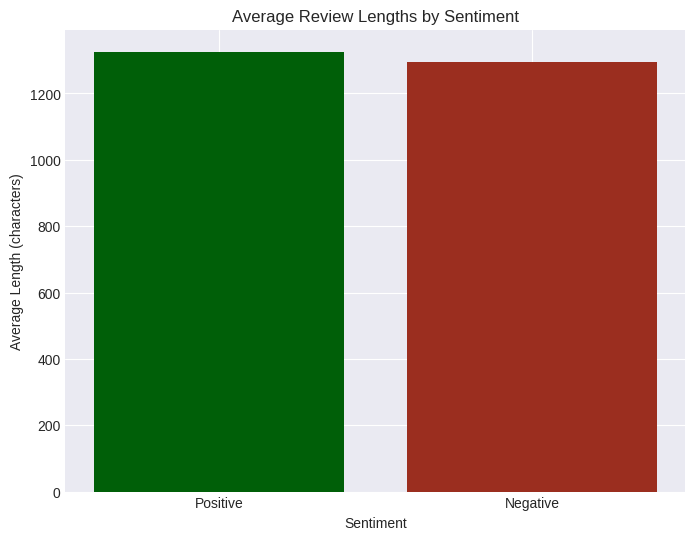

In [22]:
# Calculate average review length
average_positive_length = df.loc[df["sentiment"] == 1, "review"].apply(len).mean()
average_negative_length = df.loc[df["sentiment"] == 0, "review"].apply(len).mean()

# Create a bar chart
labels = ["Positive", "Negative"]
average_lengths = [average_positive_length, average_negative_length]

plt.figure(figsize=(8, 6))
plt.bar(labels, average_lengths, color=['#005F08', '#9B2E1F'])

plt.title("Average Review Lengths by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Length (characters)")

plt.show()

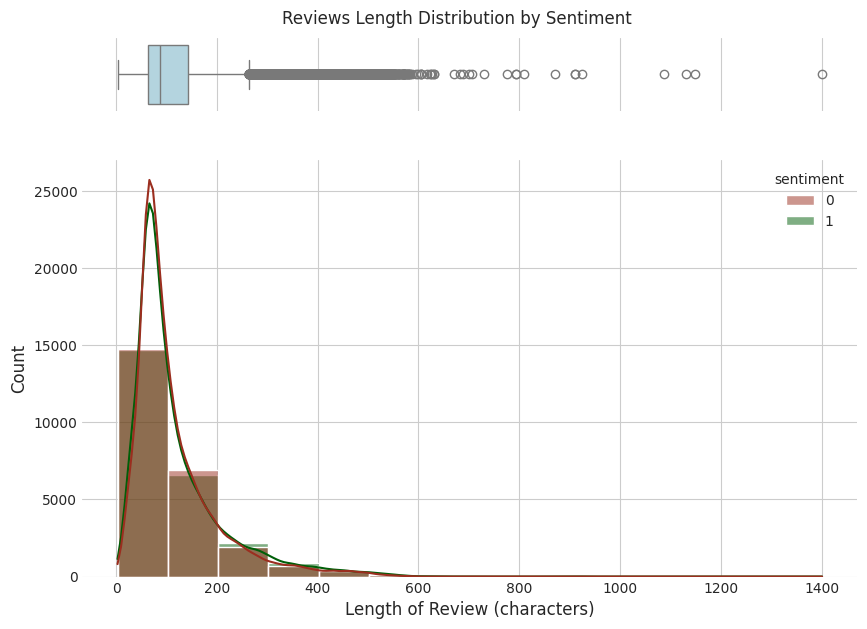

In [30]:
# Create review_length 
df['review_length'] = df["cleaned_review"].str.split().str.len()

# Set plot style
sns.set_style("whitegrid")

# Define fixed palette
custom_palette = {
    1: "#005F08",
    0: "#9B2E1F"
}

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)}, 
                                    figsize=(10, 7))
sns.boxplot(data=df, x="review_length", ax=ax_box, color='lightblue')
ax_box.set(xlabel='') 
sns.histplot(
    data=df,
    x='review_length',
    hue='sentiment',
    palette=custom_palette,
    binwidth=100,
    kde=True
)
f.suptitle("Reviews Length Distribution by Sentiment", y=0.92) 
# # Title & axis labels
plt.xlabel("Length of Review (characters)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()


In [32]:
min_review_length = df['review_length'].min()
print(f"The shortest review has {min_review_length} words.")
print("The shortest review is:", df.loc[df['review_length'] == min_review_length, 'cleaned_review'].values[0])
print("Sentiment:", df.loc[df['review_length'] == min_review_length, 'sentiment'].values[0])


The shortest review has 3 words.
The shortest review is: script story mess
Sentiment: 0


In [33]:
print(f"99.9% of the data is shorter than : {df['review_length'].quantile(0.999)} words")

99.9% of the data is shorter than : 567.4190000000017 words


In [34]:
# Considerando reseñas con hasta p99.9
df_filtered = df[df['review_length'] <= df['review_length'].quantile(0.999)]

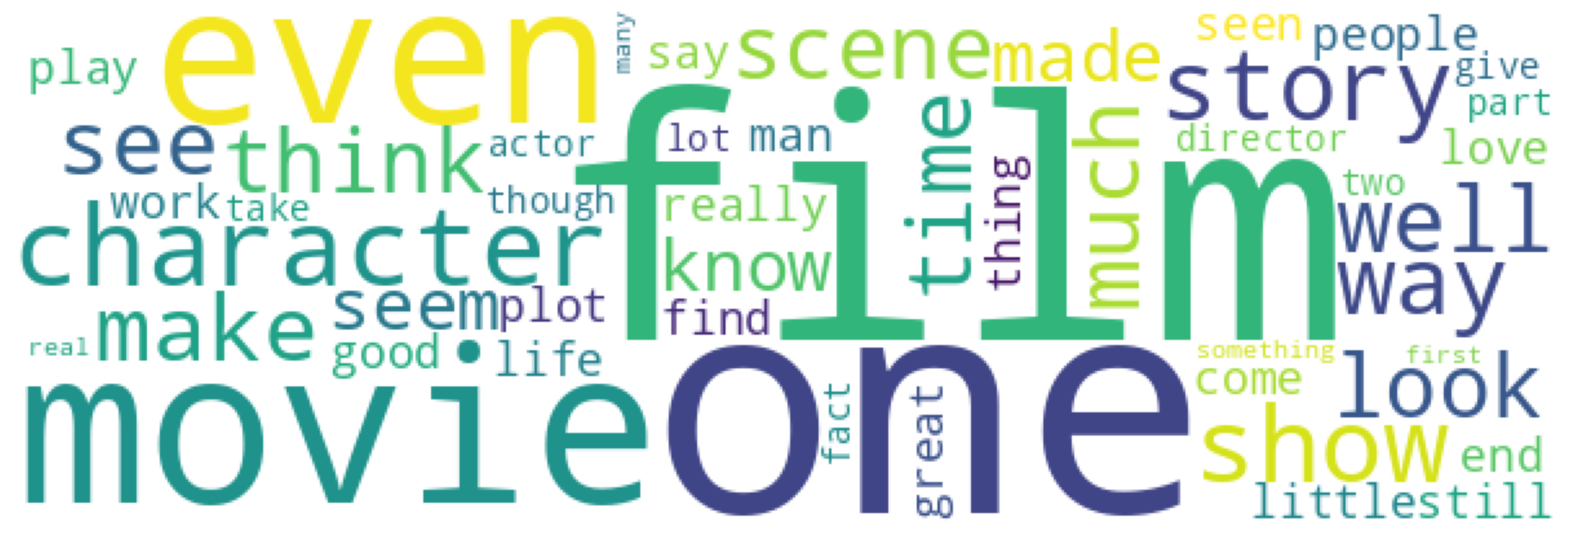

In [53]:
MostWordsUsed = WordCloud(
    max_words = 50,
    background_color='white' , 
    width = 600 , 
).generate(''.join(df_filtered['cleaned_review']))

plt.figure(figsize=(20,15))
plt.imshow(MostWordsUsed) 
plt.axis('off')
plt.show()



In [ ]:
# Saving cleaned data
cleaned_file_path = DATA_PATH / "processed/cleaned_sentiment_data.csv"
columns_to_save = ['cleaned_review', 'sentiment', 'review_length']
df[columns_to_save].to_csv(cleaned_file_path, index=False)



In [5]:

# read cleaned data
cleaned_file_path = DATA_PATH / "processed/cleaned_sentiment_data.csv"
df = pd.read_csv(cleaned_file_path)

Hemos cargado un conjunto de datos con 50,000 reseñas de películas de IMDB, cada una etiquetada como positiva o negativa. Luego de una inspección inicial, hemos identificado algunos problemas en los datos que necesitan ser abordados: duplicidad y formato inconsistente de texto.

Adicionalmente, notamos que ambas categorias se encuentran balanceadas, lo cual es beneficioso para el entrenamiento de modelos de clasificación. Aunque el dataset está balanceado, la distribución es asimétrica a derechas, indicando que la mayoría de las reseñas tienden a ser más cortas, con algunas reseñas significativamente largas que aumentan el promedio.